<a href="https://colab.research.google.com/github/devdoe153/llm_voice/blob/main/%ED%99%94%EC%9E%90%EB%B6%84%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install pyannote.audio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.6 MB/s eta 0:00:00

In [2]:
# sample data
!wget -q https://github.com/pyannote/pyannote-audio/raw/develop/tests/data/dev00.wav
!wget -q https://github.com/pyannote/pyannote-audio/raw/develop/tests/data/debug.development.rttm

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
import datetime
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pyannote.audio

In [13]:
def read_rttm(file_path):
    rttm_data = {}

    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()

            if parts[0] == 'SPEAKER' and len(parts) == 10:
                file_id = parts[1]
                start_time = float(parts[3])
                duration = float(parts[4])
                speaker_id = parts[7]

                if file_id not in rttm_data:
                    rttm_data[file_id] = []

                rttm_data[file_id].append({
                    'start_time': start_time,
                    'duration': duration,
                    'speaker_id': speaker_id
                })

    return rttm_data

def raw_waveplot(signal, figsize=(10, 3), tick_interval=10):
    fs = 16000

    plt.figure(figsize=figsize)
    plt.plot(np.linspace(0, len(signal) / fs, len(signal)), signal, color='blue')

    plt.xlabel('Time (s)')
    plt.xlim([0, len(signal) / fs])

    xticks = np.arange(0, (len(signal) // fs) + 1, tick_interval)
    xtick_labels = [str(datetime.timedelta(seconds=int(x))) for x in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels)

    max_amp = np.max(np.abs([np.max(signal), np.min(signal)]))
    plt.ylim([-max_amp, max_amp])
    plt.title('Raw Waveform plot')
    plt.tight_layout()

    return plt.gcf()

def answer_waveplot(signal, segments, colors, figsize=(10, 3), tick_interval=10):
    fs = 16000
    plt.figure(figsize=figsize)
    plt.plot(np.linspace(0, len(signal) / fs, len(signal)), signal, color='lightgrey', label='Background')

    for seg in segments:
        start_sample = int(seg['start_time'] * fs)
        # Calculate end_time using start_time and duration
        end_time = seg['start_time'] + seg['duration']
        end_sample = int(end_time * fs)
        speech = signal[start_sample:end_sample]
        # Use end_time in the plot
        plt.plot(np.linspace(seg['start_time'], end_time, len(speech)), speech, color=colors[seg['speaker_id']], label=seg)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.xlabel("Time")
    plt.xlim([0, len(signal) / fs])

    xticks = np.arange(0, (len(signal) // fs) + 1, tick_interval)
    xtick_labels = [str(datetime.timedelta(seconds=int(x))) for x in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels)

    plt.ylabel("Amplitude")
    plt.title('Answer Waveform plot')
    plt.tight_layout()

    return plt.gcf()







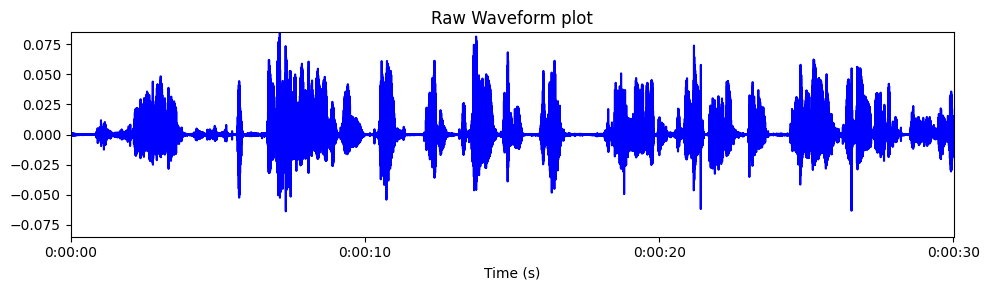

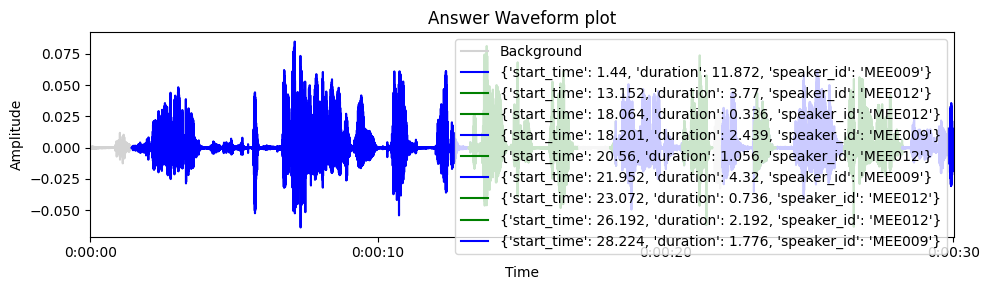

In [14]:
file_path = 'debug.development.rttm'
rttm_content = read_rttm(file_path)

WAV_FILE = 'dev00.wav'
sampling_freq, audio = wavfile.read(WAV_FILE)

raw_waveplot(audio)
colors = {'MEE009': 'blue', 'MEE012': 'green'}
answer_waveplot(audio, rttm_content['dev00'], colors)
plt.show()

In [17]:
from pyannote.audio import Pipeline
import torch

pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1")
pipeline.to(torch.device("cuda"))

config.yaml:   0%|          | 0.00/469 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [21]:
NUM_SPEAKERS = 2

start_time = time.time()
diarization = pipeline(WAV_FILE, num_speakers=NUM_SPEAKERS)
end_time = time.time()
print(f"Elapsed time: {end_time - start_time} seconds")

Elapsed time: 1.076399326324463 seconds


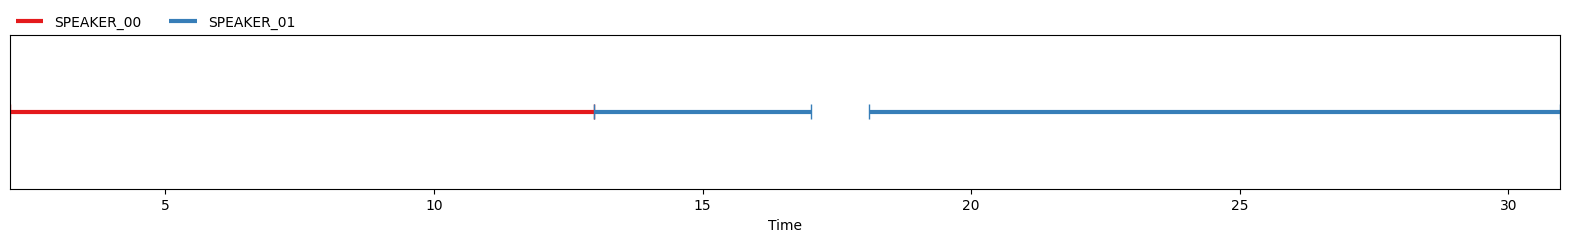

In [19]:
diarization

In [23]:
segments = diarization.to_lab()
print(segments )

2.107 12.974 SPEAKER_00
12.974 17.024 SPEAKER_01
18.104 30.963 SPEAKER_01



In [24]:
def read_pyannote_result(segments):
  segments_data = {"segments": []}
  segments = segments.strip().split('\n')

  for line in segments:
    parts = line.strip().split()

    start_time = float(parts[0])
    duration = float(parts[1])
    speaker_id = parts[2]

    segments_data["segments"].append({
        "start_time": start_time,
        "duration": duration,
        "speaker_id": speaker_id
    })

  return segments_data

result = read_pyannote_result(segments)
result


{'segments': [{'start_time': 2.107,
   'duration': 12.974,
   'speaker_id': 'SPEAKER_00'},
  {'start_time': 12.974, 'duration': 17.024, 'speaker_id': 'SPEAKER_01'},
  {'start_time': 18.104, 'duration': 30.963, 'speaker_id': 'SPEAKER_01'}]}

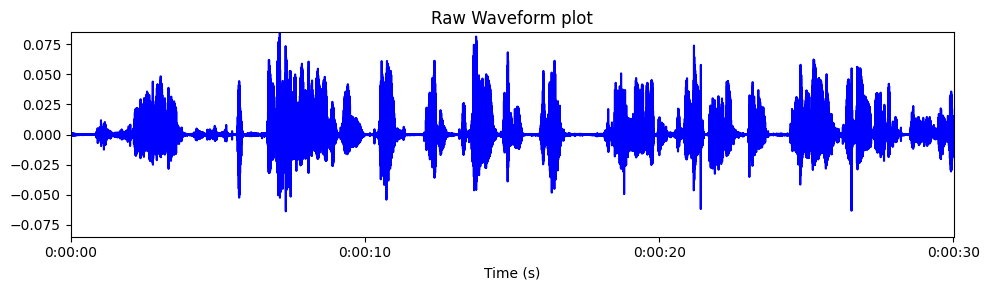

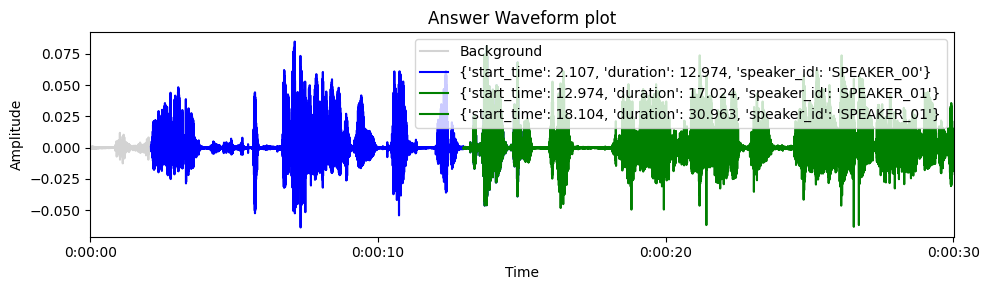

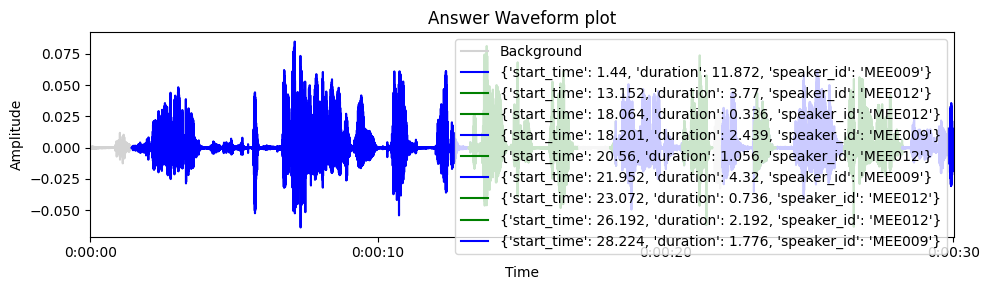

In [25]:
raw_waveplot(audio)

colors = {'SPEAKER_00': 'blue', 'SPEAKER_01': 'green'}
answer_waveplot(audio, result['segments'], colors)


colors = {'MEE009': 'blue', 'MEE012': 'green'}
answer_waveplot(audio, rttm_content['dev00'], colors)
plt.show()

In [28]:
from pyannote.audio import Pipeline
import torch

pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1")
pipeline.to(torch.device("cpu"))

In [ ]:
NUM_SPEAKERS = 2

start_time = time.time()
diarization = pipeline(WAV_FILE, num_speakers=NUM_SPEAKERS)
end_time = time.time()
print(f"Elapsed time: {end_time - start_time} seconds")

/usr/local/lib/python3.10/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correction=1)
